
\cleardoublepage


### Activities only - performance on validation set



In [1]:
variant_codename = 'LonelyEnragedAppalled'

import sys
import yaml
sys.path.append('code')
from etl_hapt import get_Xy_data_sets
from pipelines import run_default_etl_pipeline, run_default_preprocessing_pipeline
from normalizer import fit_standard_scaler_to_sequence_batch, normalize_sequence_batch

yaml_config = \
"""
01_etl:
    data_set_dir: '/home/fabian/repositories/masterthesis_reloaded/data/HAPT Data Set'
    download_url: 'https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip'
    data_split:
      train_participant_ids: [20,  6, 22, 18, 26, 27,  3, 11, 13, 30, 19, 12, 10, 17, 21,  4, 14, 24]
      test_participant_ids: [16, 28,  2,  1, 23, 25]
      validation_participant_ids: [ 7,  9, 15, 29,  8,  5]
    selected_labels: [1,2,3,4,5,6]
    channel_names_prior_preprocess: ['gyro-X', 'gyro-Y', 'gyro-Z', 'acc-X', 'acc-Y', 'acc-Z']
    channl_names_post_preprocess: ['gyro-X', 'gyro-Y', 'gyro-Z', 'body-X', 'body-Y', 'body-Z', 'gravity-X', 'gravity-Y', 'gravity-Z']
    sequence_length: 64
    sequence_stepsize: 32
    drop_columns: ['participant_id', 'experiment_id', 'time'] # the columns are loaded initially, because they are needed to sort and group data, but should not be used for modeling  
    group_column: 'experiment_id' # data is sequenced within these groups
02_preprocessing:
    sample_rate: 50
    median_filter_kernel: 3
    acc_columns_idx: [3,4,5] # indices of columns that contain the acceleration data
"""

yaml_config_model = \
"""
lstm_layer:
  units: 50
  activation: relu
  dropout: 0.0
  kernel_regularizer_l2: 0.001
  activity_regularizer_l1: 0.001
output_layer:
  activation: softmax
  kernel_regularizer_l2: 0.001
  activity_regularizer_l1: 0.001
loss: categorical_crossentropy
optimizer:
  adam:
    lr: 0.001
    beta_1: 0.9
    beta_2: 0.999
    decay: 0.0
metrics: ['accuracy']
epochs: 100
batch_size: 200

"""

%load_ext autoreload
%autoreload 2
config = yaml.load(yaml_config)
etl_config = config['01_etl']
preprocessing_config = config['02_preprocessing']
model_config = yaml.load(yaml_config_model)
df_Xy_train, df_Xy_validation  = \
get_Xy_data_sets(
etl_config['data_set_dir'],
etl_config['download_url'],
ids_train=etl_config['data_split']['train_participant_ids'],
ids_validation=etl_config['data_split']['validation_participant_ids'],
)

X_train, y_train, y_train_binary = \
run_default_etl_pipeline(df_Xy_train, etl_config)

X_validation, y_validation, y_validation_binary = \
run_default_etl_pipeline(df_Xy_validation, etl_config)


X_train = run_default_preprocessing_pipeline(
X_train, preprocessing_config)
X_validation = run_default_preprocessing_pipeline(
X_validation, preprocessing_config)


means, variances = fit_standard_scaler_to_sequence_batch(X_train)
X_train = normalize_sequence_batch(X_train, means, variances)
X_validation = normalize_sequence_batch(X_validation, means, variances)



Xy shape:  (1122772, 10)
kept columns:  ['gyro-X' 'gyro-Y' 'gyro-Z' 'acc-X' 'acc-Y' 'acc-Z' 'activity_id']
Shape sequenced dataframe (now numpy array):  (21422, 64, 7)
kept columns:  ['gyro-X' 'gyro-Y' 'gyro-Z' 'acc-X' 'acc-Y' 'acc-Z' 'activity_id']
Shape sequenced dataframe (now numpy array):  (6225, 64, 7)


/home/fabian/.miniconda3/envs/masterthesis_tf_keras/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Shape BEFORE separating acc and body:  (13255, 64, 6)
Shape AFTER separating acc and body:  (13255, 64, 9)
Shape BEFORE separating acc and body:  (3913, 64, 6)
Shape AFTER separating acc and body:  (3913, 64, 9)


In [2]:
import numpy as np
np.random.seed(2)
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras import optimizers
from keras import regularizers
from keras import metrics
import pickle
import os
from plotting import plot_acc_loss_model_history, plot_multi_class_roc, set_mixed_color_linestyle_cycler

model_filepath = 'models/%s_model.h5' % variant_codename
history_filepath = 'models/%s_history.pickle' % variant_codename

# check if the model already exists. If yes the model and history can
# be loaded so the model does not have to be retrained for minor changes
# made in the document.
model = load_model(model_filepath)
with open(history_filepath, 'rb') as handle:
    history = pickle.load(handle)


from etl_hapt import reverse_label_binarize
y_validation_pred_binary = model.predict(X_validation)
y_validation_pred = reverse_label_binarize(y_validation_pred_binary, etl_config['selected_labels'])
overall_validation_acc = sum(y_validation == y_validation_pred)/len(y_validation) * 100



Using TensorFlow backend.


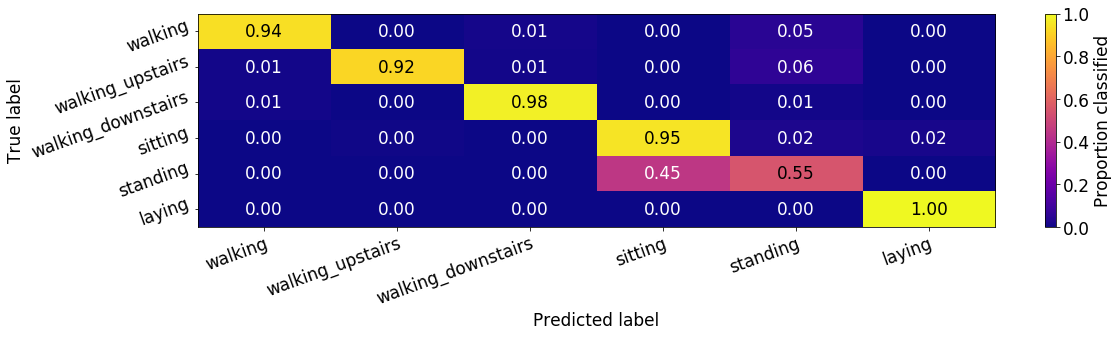

In [3]:

from plotting import plot_confusion_matrix_for_variant

plot_confusion_matrix_for_variant(model, X_validation, y_validation, etl_config,
                                  variant_codename + '_validation')



In [4]:
print(
"""
Validating the model performance of the shortened sequence (*length=64*, *stepsize=32*) variant (@sec:LonelyEnragedAppalled) on the validation set. See @lst:best_model_activities_cfg for the configuration of the LSTM. This variant has an **accuracy of %.1f%%** on the validation data set. See @fig:%s_confusion_matrix for how the model performs in classifying each label. This performance reflects how well this variant will perform on new data.
"""
% (overall_validation_acc, variant_codename + '_validation')
)





Validating the model performance of the shortened sequence (*length=64*, *stepsize=32*) variant (@sec:LonelyEnragedAppalled) on the validation set. See @lst:best_model_activities_cfg for the configuration of the LSTM. This variant has an **accuracy of 88.4%** on the validation data set. See @fig:LonelyEnragedAppalled_validation_confusion_matrix for how the model performs in classifying each label. This performance reflects how well this variant will perform on new data.



In [5]:

print(
"""
![Confusion matrix of the predictions made by the model on the validation set. The diagonal reflects the correctly classified proportions for each category.](figures/%s_confusion_matrix.png){#fig:%s_confusion_matrix}
"""
% (variant_codename + '_validation', variant_codename + '_validation')
)



![Confusion matrix of the predictions made by the model on the validation set. The diagonal reflects the correctly classified proportions for each category.](figures/LonelyEnragedAppalled_validation_confusion_matrix.png){#fig:LonelyEnragedAppalled_validation_confusion_matrix}

